Борисенко Дмитрий Антонович РИ-230945

# Imports

In [29]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import time

# Utils

In [26]:
def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()


def count_parameters(model):
    """Подсчитывает количество параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def save_model(model, path):
    """Сохраняет модель"""
    torch.save(model.state_dict(), path)


def load_model(model, path):
    """Загружает модель"""
    model.load_state_dict(torch.load(path))
    return model


def compare_models(first_history, second_history, first_title='A', second_title='B'):
    """Сравнивает результаты полносвязной и сверточной сетей"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(first_history['test_accs'], label=first_title, marker='o')
    ax1.plot(second_history['test_accs'], label=second_title, marker='s')
    ax1.set_title('Test Accuracy Comparison')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(first_history['test_losses'], label=first_title, marker='o')
    ax2.plot(second_history['test_losses'], label=second_title, marker='s')
    ax2.set_title('Test Loss Comparison')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()



def plot_confusion_matrix(y_true, y_pred, class_names):
    """Confusion Matrix"""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')


def plot_grad_flow(named_parameters):
    """Анализ взрыва/затухания градиентов"""
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and p.grad is not None:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().item())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k")
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title("Gradient Flow")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Datasets

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


class CIFARDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.CIFAR10(
            root='./data',
            train=train,
            download=True,
            transform=transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


def get_cifar_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    train_dataset = CIFARDataset(train=True, transform=transform)
    test_dataset = CIFARDataset(train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Trainer

In [19]:
def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        data, target = data.to(device), target.to(device)

        if not is_test and optimizer is not None:
            optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return total_loss / len(data_loader), correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

# Задание 1: Сравнение CNN и полносвязных сетей

1.1 Сравнение на MNIST (20 баллов)

Сравните производительность на MNIST:

- Полносвязная сеть (3-4 слоя)
- Простая CNN (2-3 conv слоя)
- CNN с Residual Block

Для каждого варианта:
- Обучите модель с одинаковыми гиперпараметрами
- Сравните точность на train и test множествах
- Измерьте время обучения и инференса
- Визуализируйте кривые обучения
- Проанализируйте количество параметров

In [9]:
class FullyConnected(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28 * input_channels, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class CNNWithResidual(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)

        self.res1 = ResidualBlock(32, 32)
        self.res2 = ResidualBlock(32, 64, 2)
        self.res3 = ResidualBlock(64, 64)

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Сравнение на MNIST

Using device: cuda
Fully Connected parameters: 235146
Simple CNN parameters: 421642
Residual CNN parameters: 160906
Training Fully Connected...


100%|██████████| 157/157 [00:02<00:00, 54.73it/s]


Epoch 1/5:
Train Loss: 0.2298, Train Acc: 0.9305
Test Loss: 0.1162, Test Acc: 0.9629
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 86.65it/s]


Epoch 2/5:
Train Loss: 0.0948, Train Acc: 0.9708
Test Loss: 0.0911, Test Acc: 0.9715
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 71.11it/s]


Epoch 3/5:
Train Loss: 0.0640, Train Acc: 0.9796
Test Loss: 0.0895, Test Acc: 0.9729
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 85.73it/s]


Epoch 4/5:
Train Loss: 0.0486, Train Acc: 0.9845
Test Loss: 0.0825, Test Acc: 0.9765
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 86.14it/s]


Epoch 5/5:
Train Loss: 0.0398, Train Acc: 0.9871
Test Loss: 0.0743, Test Acc: 0.9793
--------------------------------------------------
Training Simple CNN...


100%|██████████| 157/157 [00:02<00:00, 66.26it/s]


Epoch 1/5:
Train Loss: 0.1704, Train Acc: 0.9473
Test Loss: 0.0409, Test Acc: 0.9873
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 78.36it/s]


Epoch 2/5:
Train Loss: 0.0534, Train Acc: 0.9838
Test Loss: 0.0295, Test Acc: 0.9897
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 78.14it/s]


Epoch 3/5:
Train Loss: 0.0389, Train Acc: 0.9878
Test Loss: 0.0343, Test Acc: 0.9896
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 75.90it/s]


Epoch 4/5:
Train Loss: 0.0309, Train Acc: 0.9908
Test Loss: 0.0261, Test Acc: 0.9910
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 68.51it/s]


Epoch 5/5:
Train Loss: 0.0244, Train Acc: 0.9921
Test Loss: 0.0242, Test Acc: 0.9915
--------------------------------------------------
Training Residual CNN...


100%|██████████| 157/157 [00:02<00:00, 64.77it/s]


Epoch 1/5:
Train Loss: 0.1126, Train Acc: 0.9663
Test Loss: 0.0585, Test Acc: 0.9814
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 70.58it/s]


Epoch 2/5:
Train Loss: 0.0389, Train Acc: 0.9875
Test Loss: 0.0369, Test Acc: 0.9877
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 72.73it/s]


Epoch 3/5:
Train Loss: 0.0288, Train Acc: 0.9912
Test Loss: 0.0210, Test Acc: 0.9934
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 63.07it/s]


Epoch 4/5:
Train Loss: 0.0257, Train Acc: 0.9919
Test Loss: 0.0257, Test Acc: 0.9922
--------------------------------------------------


100%|██████████| 157/157 [00:03<00:00, 51.02it/s]


Epoch 5/5:
Train Loss: 0.0226, Train Acc: 0.9930
Test Loss: 0.0247, Test Acc: 0.9919
--------------------------------------------------


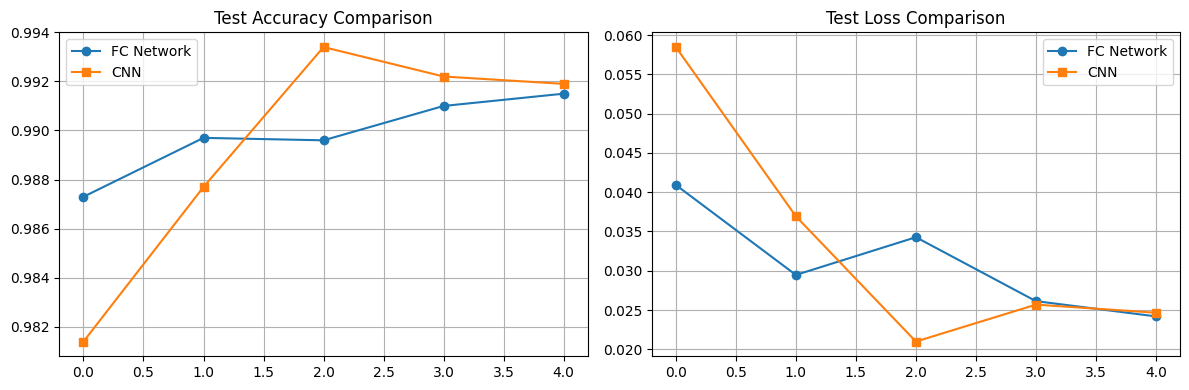

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_loader, test_loader = get_mnist_loaders(batch_size=64)

simple_cnn = SimpleCNN(input_channels=1, num_classes=10).to(device)
residual_cnn = CNNWithResidual(input_channels=1, num_classes=10).to(device)
fully_connected = FullyConnected(input_channels=1, num_classes=10).to(device)

print(f"Fully Connected parameters: {count_parameters(fully_connected)}")
print(f"Simple CNN parameters: {count_parameters(simple_cnn)}")
print(f"Residual CNN parameters: {count_parameters(residual_cnn)}")

print("Training Fully Connected...")
connected_history = train_model(fully_connected, train_loader, test_loader, epochs=5, device=str(device))

print("Training Simple CNN...")
simple_history = train_model(simple_cnn, train_loader, test_loader, epochs=5, device=str(device))

print("Training Residual CNN...")
residual_history = train_model(residual_cnn, train_loader, test_loader, epochs=5, device=str(device))

compare_models(simple_history, residual_history)

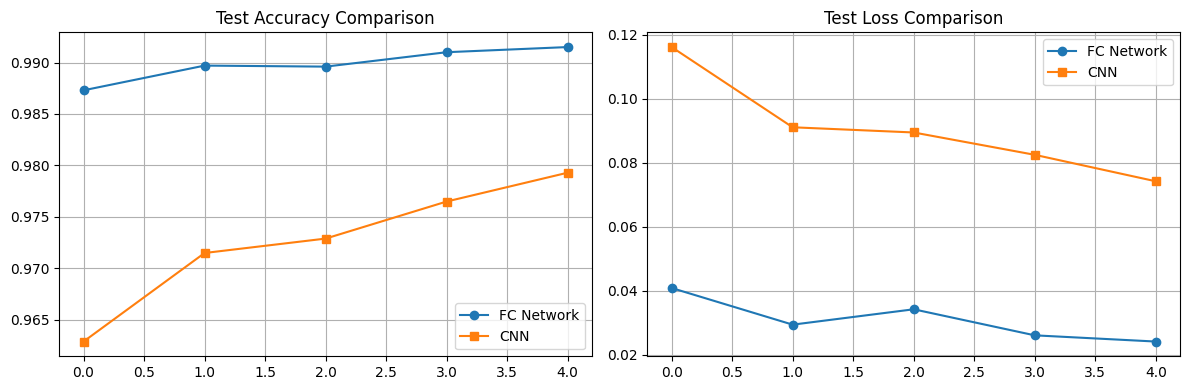

In [10]:
compare_models(simple_history, connected_history)

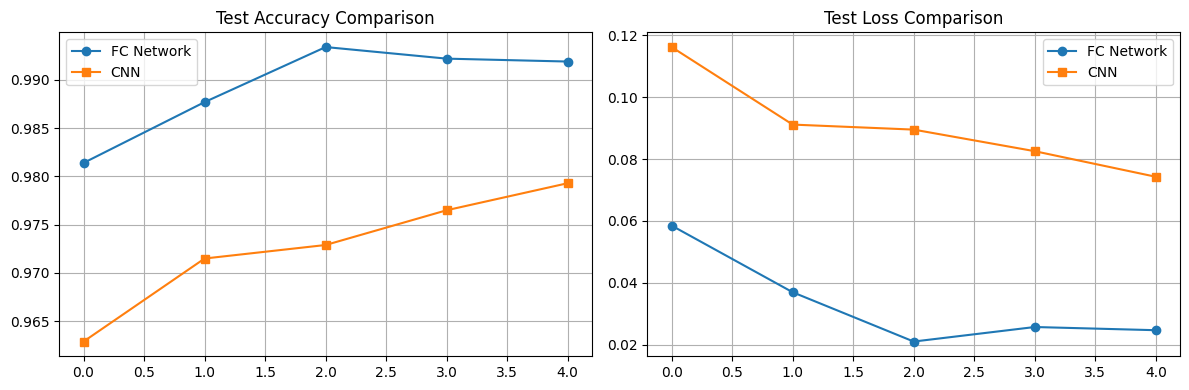

In [11]:
compare_models(residual_history, connected_history)

1.2 Сравнение на CIFAR-10 (20 баллов)

Сравните производительность на CIFAR-10:
- Полносвязная сеть (глубокая)
- CNN с Residual блоками
- CNN с регуляризацией и Residual блоками

Для каждого варианта:
- Обучите модель с одинаковыми гиперпараметрами
- Сравните точность и время обучения
- Проанализируйте переобучение
- Визуализируйте confusion matrix
- Исследуйте градиенты (gradient flow)

In [13]:
class FullyConnected(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * input_channels, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class CNNWithResidual(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)

        self.res1 = ResidualBlock(32, 32)
        self.res2 = ResidualBlock(32, 64, 2)
        self.res3 = ResidualBlock(64, 64)

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class CNNWithRegularization(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)

        self.res1 = ResidualBlock(32, 32)
        self.drop1 = nn.Dropout(0.3)

        self.res2 = ResidualBlock(32, 64, 2)
        self.drop2 = nn.Dropout(0.4)

        self.res3 = ResidualBlock(64, 64)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop1(self.res1(x))
        x = self.drop2(self.res2(x))
        x = self.res3(x)
        x = self.pool(x)
        x = self.fc(x)
        return x

Fully Connected parameters: 3805450
CNN With Regularization parameters: 283722
Residual CNN parameters: 161482
Training Fully Connected...


100%|██████████| 157/157 [00:02<00:00, 63.27it/s]


Epoch 1/5:
Train Loss: 1.6824, Train Acc: 0.4027
Test Loss: 1.5702, Test Acc: 0.4362
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 69.68it/s]


Epoch 2/5:
Train Loss: 1.4775, Train Acc: 0.4764
Test Loss: 1.4592, Test Acc: 0.4837
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 68.72it/s]


Epoch 3/5:
Train Loss: 1.3746, Train Acc: 0.5142
Test Loss: 1.4163, Test Acc: 0.5097
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 55.46it/s]


Epoch 4/5:
Train Loss: 1.2918, Train Acc: 0.5428
Test Loss: 1.4229, Test Acc: 0.5105
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 68.05it/s]


Epoch 5/5:
Train Loss: 1.2222, Train Acc: 0.5672
Test Loss: 1.3997, Test Acc: 0.5172
--------------------------------------------------


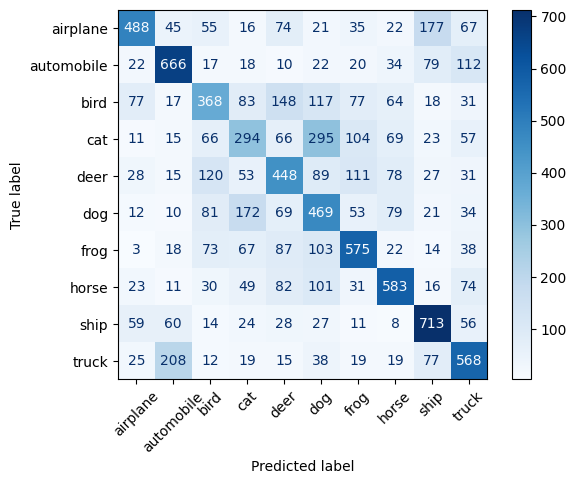

In [21]:
train_loader, test_loader = get_cifar_loaders(batch_size=64)

cnn_with_reg = CNNWithRegularization(input_channels=3, num_classes=10).to(device)
residual_cnn = CNNWithResidual(input_channels=3, num_classes=10).to(device)
fully_connected = FullyConnected(input_channels=3, num_classes=10).to(device)

print(f"Fully Connected parameters: {count_parameters(fully_connected)}")
print(f"CNN With Regularization parameters: {count_parameters(cnn_with_reg)}")
print(f"Residual CNN parameters: {count_parameters(residual_cnn)}")

print("Training Fully Connected...")
connected_history = train_model(fully_connected, train_loader, test_loader, epochs=5, device=str(device))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
fully_connected.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = fully_connected(inputs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
plot_confusion_matrix(y_true, y_pred, class_names)

Training CNN With Regularization...


100%|██████████| 157/157 [00:02<00:00, 60.74it/s]


Epoch 1/5:
Train Loss: 1.5494, Train Acc: 0.4317
Test Loss: 1.3225, Test Acc: 0.5123
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 59.02it/s]


Epoch 2/5:
Train Loss: 1.2149, Train Acc: 0.5639
Test Loss: 1.0511, Test Acc: 0.6129
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 57.16it/s]


Epoch 3/5:
Train Loss: 1.0888, Train Acc: 0.6129
Test Loss: 0.9473, Test Acc: 0.6653
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 57.33it/s]


Epoch 4/5:
Train Loss: 0.9910, Train Acc: 0.6499
Test Loss: 0.8497, Test Acc: 0.6993
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 55.58it/s]


Epoch 5/5:
Train Loss: 0.9337, Train Acc: 0.6727
Test Loss: 0.7552, Test Acc: 0.7354
--------------------------------------------------


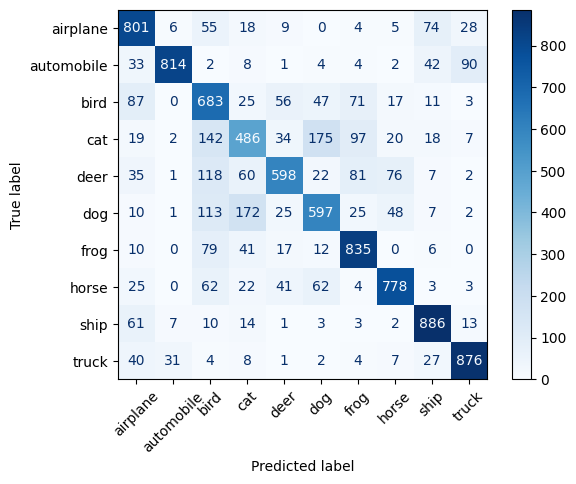

In [22]:
print("Training CNN With Regularization...")
regularization_history = train_model(cnn_with_reg, train_loader, test_loader, epochs=5, device=str(device))
cnn_with_reg.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = cnn_with_reg(inputs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
plot_confusion_matrix(y_true, y_pred, class_names)

Training Residual CNN...


100%|██████████| 157/157 [00:03<00:00, 48.84it/s]


Epoch 1/5:
Train Loss: 1.1406, Train Acc: 0.5932
Test Loss: 1.1917, Test Acc: 0.6057
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 59.80it/s]


Epoch 2/5:
Train Loss: 0.7781, Train Acc: 0.7251
Test Loss: 0.7311, Test Acc: 0.7429
--------------------------------------------------


100%|██████████| 157/157 [00:03<00:00, 44.28it/s]


Epoch 3/5:
Train Loss: 0.6488, Train Acc: 0.7736
Test Loss: 0.7204, Test Acc: 0.7464
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 58.01it/s]


Epoch 4/5:
Train Loss: 0.5681, Train Acc: 0.8032
Test Loss: 0.6535, Test Acc: 0.7743
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 59.55it/s]


Epoch 5/5:
Train Loss: 0.4922, Train Acc: 0.8294
Test Loss: 0.6459, Test Acc: 0.7823
--------------------------------------------------


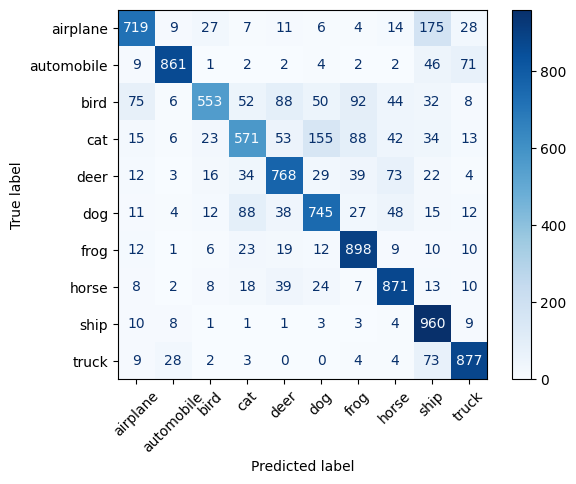

In [23]:
print("Training Residual CNN...")
residual_history = train_model(residual_cnn, train_loader, test_loader, epochs=5, device=str(device))
residual_cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = residual_cnn(inputs)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
plot_confusion_matrix(y_true, y_pred, class_names)

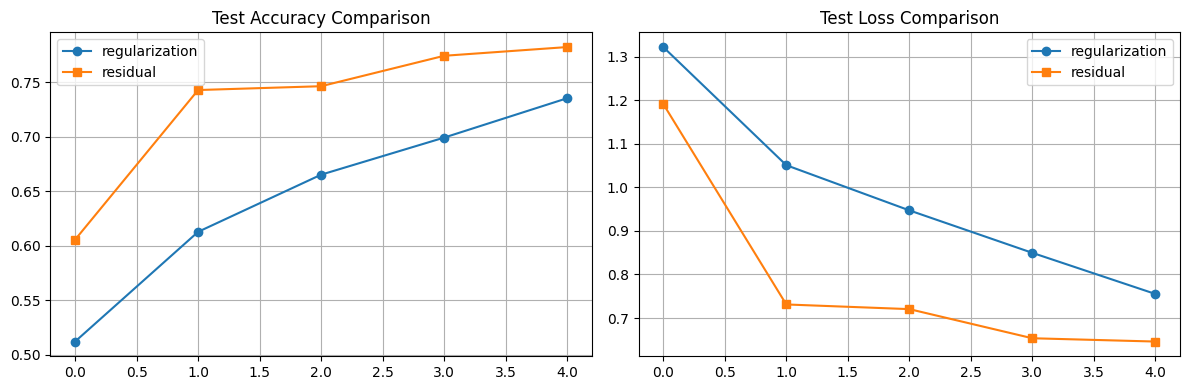

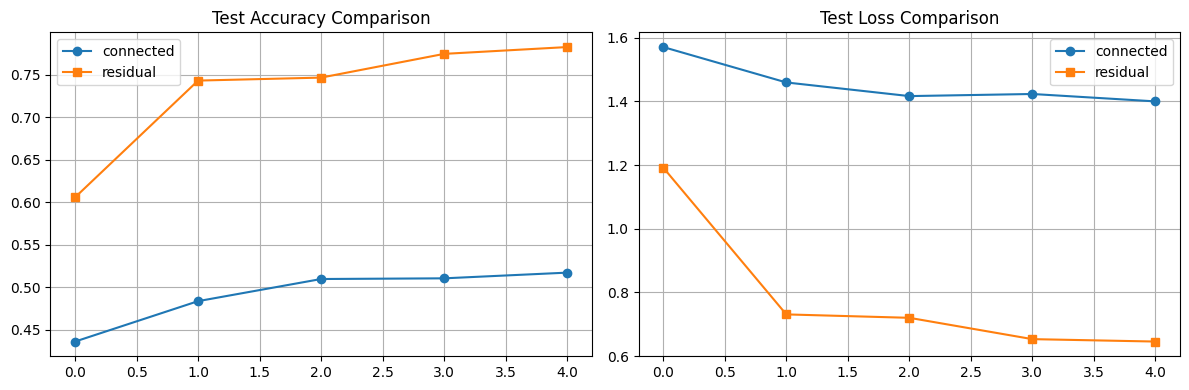

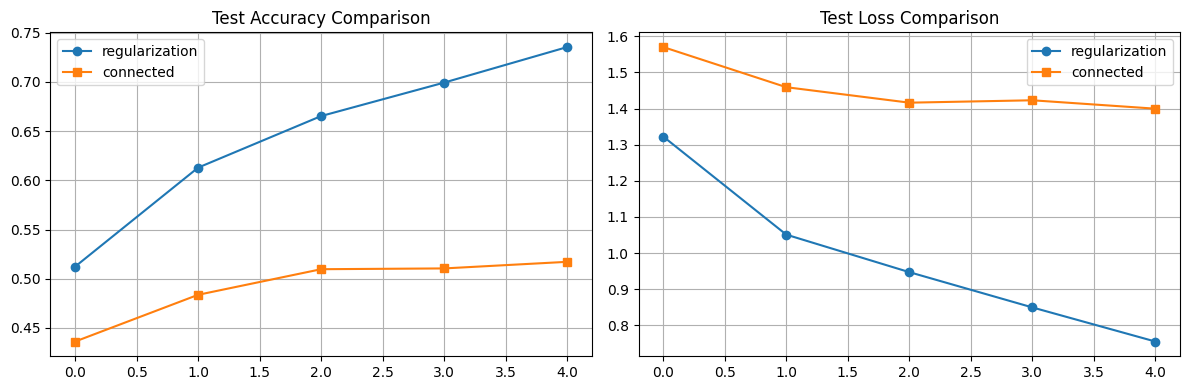

In [27]:
compare_models(regularization_history, residual_history, 'regularization', 'residual')
compare_models(connected_history, residual_history, 'connected', 'residual')
compare_models(regularization_history, connected_history, 'regularization', 'connected')

# Задание 2: Анализ архитектур CNN

2.1 Влияние размера ядра свертки (15 баллов)

Исследуйте влияние размера ядра свертки:
- 3x3 ядра
- 5x5 ядра
- 7x7 ядра
- Комбинация разных размеров (1x1 + 3x3)

Для каждого варианта:
- Поддерживайте одинаковое количество параметров
- Сравните точность и время обучения
- Проанализируйте рецептивные поля
- Визуализируйте активации первого слоя

In [35]:
class ConvNet3x3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class ConvNet5x5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=5, padding=2)  # меньше каналов, чтобы ~равные параметры
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(20 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ConvNet7x7(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 14, kernel_size=7, padding=3)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(14 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ConvNet1x1_3x3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1x1 = nn.Conv2d(3, 16, kernel_size=1)
        self.conv3x3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.conv1x1(x))
        x = F.relu(self.conv3x3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [36]:
def train_and_evaluate(model, train_loader, test_loader, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    start_time = time.time()
    for epoch in range(5):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    train_time = time.time() - start_time

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc, train_time

In [37]:
def visualize_first_layer(model, loader, device):
    model.eval()
    images, _ = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        if hasattr(model, 'conv1'):
            activations = model.conv1(images)
        elif hasattr(model, 'conv1x1'):
            x = F.relu(model.conv1x1(images))
            activations = model.conv3x3(x)
        else:
            print("Нет conv слоя")
            return

    act = activations[0].cpu()
    fig, axes = plt.subplots(1, min(6, act.shape[0]), figsize=(15, 3))
    for i in range(len(axes)):
        axes[i].imshow(act[i], cmap='viridis')
        axes[i].axis('off')
    plt.suptitle("Активации первого сверточного слоя")
    plt.show()

[3x3] Accuracy: 0.5422, Time: 62.20 sec


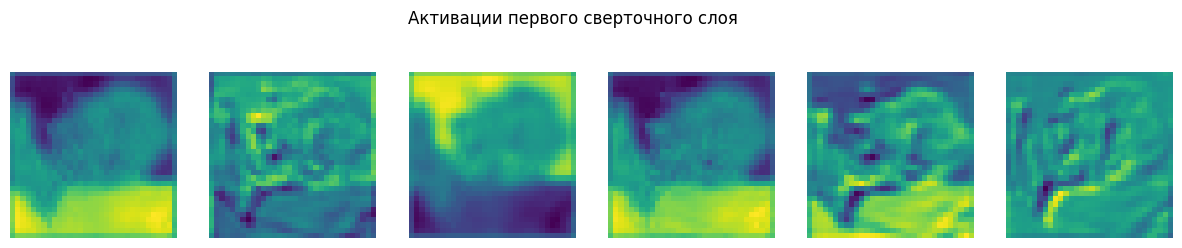

--------------------------------------------------
[5x5] Accuracy: 0.5436, Time: 60.54 sec


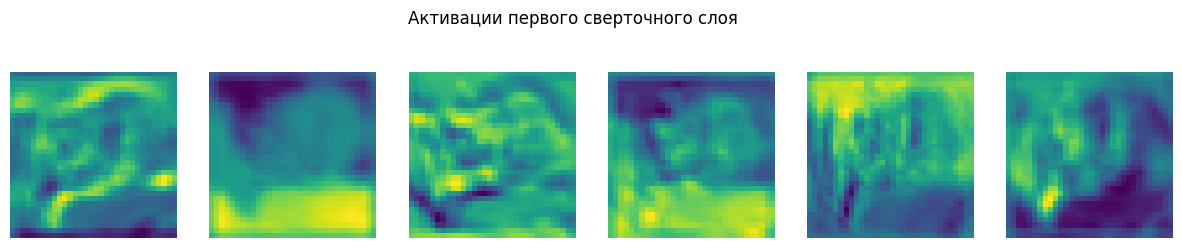

--------------------------------------------------
[7x7] Accuracy: 0.5296, Time: 60.95 sec


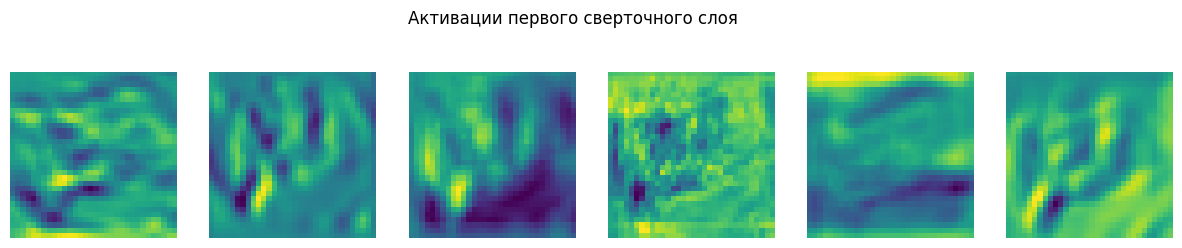

--------------------------------------------------
[1x1+3x3] Accuracy: 0.5542, Time: 61.87 sec


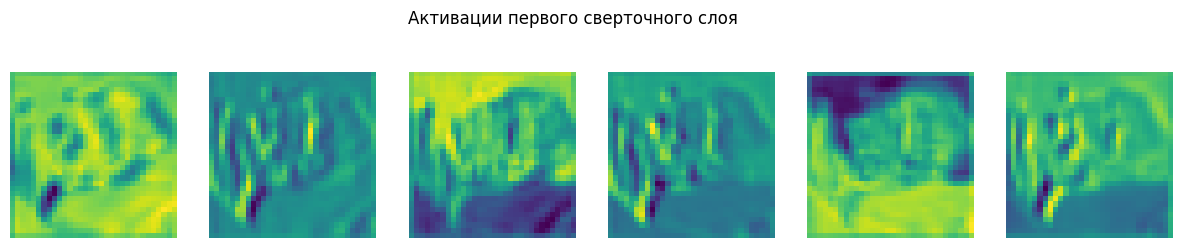

--------------------------------------------------


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = [
    ("3x3", ConvNet3x3()),
    ("5x5", ConvNet5x5()),
    ("7x7", ConvNet7x7()),
    ("1x1+3x3", ConvNet1x1_3x3())
]

for name, model in models:
    acc, duration = train_and_evaluate(model, train_loader, test_loader, device)
    print(f"[{name}] Accuracy: {acc:.4f}, Time: {duration:.2f} sec")
    visualize_first_layer(model, test_loader, device)
    print("-" * 50)